In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier 
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA

# Small Dataset (a few hundred images)

In [11]:
# read in data
base_dir = '/Users/sandy/Desktop/Small Dataset'
train = os.path.join(base_dir, 'train')
validation = os.path.join(base_dir, 'validation')
test = os.path.join(base_dir, 'test')

train_aca_dir = os.path.join(train, 'lung_aca')
train_normal_dir = os.path.join(train, 'lung_n')
train_scc_dir = os.path.join(train, 'lung_scc')

validation_aca_dir = os.path.join(validation, 'lung_aca')
validation_normal_dir = os.path.join(validation, 'lung_n')
validation_scc_dir = os.path.join(validation, 'lung_scc')

test_aca_dir = os.path.join(test, 'lung_aca')
test_normal_dir = os.path.join(test, 'lung_n')
test_scc_dir = os.path.join(test, 'lung_scc')

In [3]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [10]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

In [11]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, layers

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final softmax layer for classification
x = layers.Dense(3, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# rescaling data
train_datagen = ImageDataGenerator(rescale = 1./255.)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 478 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


In [25]:

history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 3,
            epochs = 30)

Epoch 1/30
3/3 [==============================] - 2s 1s/step - loss: 0.0851 - acc: 0.9828 - val_loss: 0.3401 - val_acc: 0.8417
Epoch 2/30
3/3 [==============================] - 2s 942ms/step - loss: 0.1528 - acc: 0.9833 - val_loss: 0.3349 - val_acc: 0.8583
Epoch 3/30
3/3 [==============================] - 2s 962ms/step - loss: 0.1005 - acc: 0.9667 - val_loss: 0.3176 - val_acc: 0.8833
Epoch 4/30
3/3 [==============================] - 2s 971ms/step - loss: 0.1400 - acc: 0.9333 - val_loss: 0.3065 - val_acc: 0.8750
Epoch 5/30
3/3 [==============================] - 2s 950ms/step - loss: 0.0948 - acc: 0.9833 - val_loss: 0.3063 - val_acc: 0.8917
Epoch 6/30
3/3 [==============================] - 2s 945ms/step - loss: 0.0477 - acc: 0.9833 - val_loss: 0.2778 - val_acc: 0.9083
Epoch 7/30
3/3 [==============================] - 2s 1s/step - loss: 0.0577 - acc: 0.9828 - val_loss: 0.2690 - val_acc: 0.9000
Epoch 8/30
3/3 [==============================] - 2s 998ms/step - loss: 0.0950 - acc: 0.9667 - v

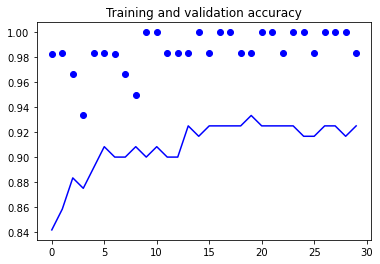

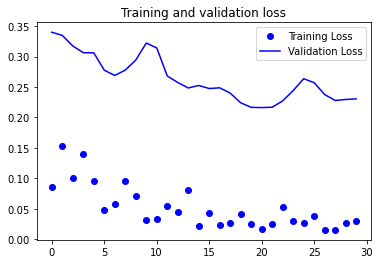

In [26]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Bigger Dataset (a few thousand images)

In [29]:
# add more data
# The path to the original directory with lung images
# dataset is uncompressed
original_dataset_dir = '/Users/sandy/Desktop/lung_colon_image_set/lung_image_sets'

# The directory where we will
# store our bigger dataset
base_dir = '/Users/sandy/Desktop/Bigger Dataset'

# Directories for our training,
# validation and test splits
train = os.path.join(base_dir, 'train')
os.mkdir(train)

validation = os.path.join(base_dir, 'validation')
test = os.path.join(base_dir, 'test')
os.mkdir(validation)

# Directory with our training aca pictures
train_aca_dir = os.path.join(train, 'lung_aca')
os.mkdir(train_aca_dir)

# Directory with our training normal pictures
train_normal_dir = os.path.join(train, 'lung_n')
os.mkdir(train_normal_dir)

# Directory with our validation aca pictures
validation_aca_dir = os.path.join(validation, 'lung_aca')
os.mkdir(validation_aca_dir)

# Directory with our validation normal pictures
validation_normal_dir = os.path.join(validation, 'lung_n')
os.mkdir(validation_normal_dir)

# Directory with our test aca pictures
test_aca_dir = os.path.join(test, 'lung_aca')
os.mkdir(test_aca_dir)

# Directory with our test normal pictures
test_normal_dir = os.path.join(test, 'lung_n')
os.mkdir(test_normal_dir)



In [31]:
import shutil

original_aca_dir = '/Users/sandy/Desktop/lung_colon_image_set/lung_image_sets/lung_aca'


# Copy first 1000 aca images to train_aca_dir
fnames = ['lungaca{}.jpeg'.format(i) for i in range(1,1001)]
for fname in fnames:
    src = os.path.join(original_aca_dir, fname)
    dst = os.path.join(train_aca_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 aca images to validation_aca_dir
fnames = ['lungaca{}.jpeg'.format(i) for i in range(1001, 1501)]
for fname in fnames:
    src = os.path.join(original_aca_dir, fname)
    dst = os.path.join(validation_aca_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 aca images to test_aca_dir
fnames = ['lungaca{}.jpeg'.format(i) for i in range(1501, 2001)]
for fname in fnames:
    src = os.path.join(original_aca_dir, fname)
    dst = os.path.join(test_aca_dir, fname)
    shutil.copyfile(src, dst)
    
original_normal_dir = '/Users/sandy/Desktop/lung_colon_image_set/lung_image_sets/lung_n'

# Copy first 1000 normal images to train_normal_dir
fnames = ['lungn{}.jpeg'.format(i) for i in range(1,1001)]
for fname in fnames:
    src = os.path.join(original_normal_dir, fname)
    dst = os.path.join(train_normal_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 normal images to validation_normal_dir
fnames = ['lungn{}.jpeg'.format(i) for i in range(1001, 1501)]
for fname in fnames:
    src = os.path.join(original_normal_dir, fname)
    dst = os.path.join(validation_normal_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 normal images to test_normal_dir
fnames = ['lungn{}.jpeg'.format(i) for i in range(1501, 2001)]
for fname in fnames:
    src = os.path.join(original_normal_dir, fname)
    dst = os.path.join(test_normal_dir, fname)
    shutil.copyfile(src, dst)
    


In [47]:
# Directory with our training scc pictures
train_scc_dir = os.path.join(train, 'lung_scc')
os.mkdir(train_scc_dir)

# Directory with our validation scc pictures
validation_scc_dir = os.path.join(validation, 'lung_scc')
os.mkdir(validation_scc_dir)


original_scc_dir = '/Users/sandy/Desktop/lung_colon_image_set/lung_image_sets/lung_scc'

# Copy first 1000 scc images to train_scc_dir
fnames = ['lungscc{}.jpeg'.format(i) for i in range(1,1001)]
for fname in fnames:
    src = os.path.join(original_scc_dir, fname)
    dst = os.path.join(train_scc_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 scc images to validation_scc_dir
fnames = ['lungscc{}.jpeg'.format(i) for i in range(1001, 1501)]
for fname in fnames:
    src = os.path.join(original_scc_dir, fname)
    dst = os.path.join(validation_scc_dir, fname)
    shutil.copyfile(src, dst)
    


In [83]:
test_scc_dir = os.path.join(test, 'lung_scc')
os.mkdir(test_scc_dir)

# Copy next 500 scc images to test_scc_dir
fnames = ['lungscc{}.jpeg'.format(i) for i in range(1501, 2001)]
for fname in fnames:
    src = os.path.join(original_scc_dir, fname)
    dst = os.path.join(test_scc_dir, fname)
    shutil.copyfile(src, dst)

In [7]:
base_dir2 = '/Users/sandy/Desktop/Bigger Dataset'
train2 = os.path.join(base_dir2, 'train')
validation2 = os.path.join(base_dir2, 'validation')
test2 = os.path.join(base_dir2, 'test')

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import Adam

# no image augmentation

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final softmax layer for classification
x = layers.Dense(3, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

# rescaling data
train_datagen2 = ImageDataGenerator(rescale = 1./255.)


# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator2 = train_datagen2.flow_from_directory(train2,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150), shuffle=False)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator2 =  test_datagen.flow_from_directory(validation2,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150), shuffle=False)

Found 3000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [14]:
# first model
callbacks = myCallback()
history = model.fit(
            train_generator2,
            validation_data = validation_generator2,
            steps_per_epoch = 75,
            epochs = 100,
            validation_steps = 25,
            callbacks=[callbacks])

Epoch 1/100
75/75 [==============================] - 33s 383ms/step - loss: 2.4806 - acc: 0.5639 - val_loss: 0.7049 - val_acc: 0.7200
Epoch 2/100
75/75 [==============================] - 27s 360ms/step - loss: 0.2639 - acc: 0.8940 - val_loss: 0.3623 - val_acc: 0.8480
Epoch 3/100
75/75 [==============================] - 27s 353ms/step - loss: 0.1535 - acc: 0.9397 - val_loss: 0.4652 - val_acc: 0.8300
Epoch 4/100
75/75 [==============================] - 27s 362ms/step - loss: 0.1841 - acc: 0.9318 - val_loss: 0.2076 - val_acc: 0.9100
Epoch 5/100
75/75 [==============================] - 28s 379ms/step - loss: 0.1441 - acc: 0.9422 - val_loss: 0.2793 - val_acc: 0.8820
Epoch 6/100
75/75 [==============================] - 29s 390ms/step - loss: 0.0980 - acc: 0.9628 - val_loss: 0.2745 - val_acc: 0.8760

Reached 99.9% accuracy so cancelling training!


In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)
history = model.fit(
            train_generator2,
            validation_data = validation_generator2,
            steps_per_epoch = 75,
            epochs = 100,
            validation_steps = 25,
            callbacks=[callback])

Epoch 1/100
75/75 [==============================] - 28s 372ms/step - loss: 0.0609 - acc: 0.9780 - val_loss: 0.1977 - val_acc: 0.9120
Epoch 2/100
75/75 [==============================] - 30s 398ms/step - loss: 0.0561 - acc: 0.9793 - val_loss: 0.1341 - val_acc: 0.9400
Epoch 3/100
75/75 [==============================] - 30s 401ms/step - loss: 0.0650 - acc: 0.9773 - val_loss: 0.1199 - val_acc: 0.9400
Epoch 4/100
75/75 [==============================] - 62s 837ms/step - loss: 0.0302 - acc: 0.9913 - val_loss: 0.1600 - val_acc: 0.9360
Epoch 5/100
75/75 [==============================] - 31s 416ms/step - loss: 0.0276 - acc: 0.9927 - val_loss: 0.2867 - val_acc: 0.8880
Epoch 6/100
75/75 [==============================] - 30s 399ms/step - loss: 0.0176 - acc: 0.9973 - val_loss: 0.2193 - val_acc: 0.9180
Epoch 7/100
75/75 [==============================] - 28s 374ms/step - loss: 0.0189 - acc: 0.9973 - val_loss: 0.1301 - val_acc: 0.9520
Epoch 8/100
75/75 [==============================] - 28s 371ms

In [43]:
model.save('final_inception.h5', model)

In [29]:
test_generator =  test_datagen.flow_from_directory(test2,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150), shuffle=False)

Found 1500 images belonging to 3 classes.


In [30]:
test_loss, test_acc = model.evaluate(test_generator,steps=50)
print('test acc:', test_acc)

50/50 [==============================] - 12s 238ms/step - loss: 0.1236 - acc: 0.9580
test acc: 0.9580000042915344


In [37]:
train_generator2.class_indices

{'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}

# Predictions

In [44]:
img = image.load_img('/Users/sandy/Desktop/lung_colon_image_set/lung_image_sets/lung_n/lungn4021.JPEG', target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])


[1. 0. 0.]


In [54]:
np.argmax(model.predict(images), axis=-1)

array([1], dtype=int64)

In [53]:
images /= 255.

In [58]:
from keras.preprocessing import image
scc = image.load_img('/Users/sandy/Desktop/lung_colon_image_set/lung_image_sets/lung_scc/lungscc4200.JPEG', target_size=(150, 150))
scc_array = image.img_to_array(scc)
scc_array = np.expand_dims(scc_array, axis=0)

image_scc = np.vstack([scc_array])
image_scc /= 255.


In [60]:
scc_pred = np.argmax(model.predict(image_scc), axis=-1)
scc_pred

array([2], dtype=int64)

In [61]:

aca = image.load_img('/Users/sandy/Desktop/lung_colon_image_set/lung_image_sets/lung_aca/lungaca3852.JPEG', target_size=(150, 150))
aca_array = image.img_to_array(aca)
aca_array = np.expand_dims(aca_array, axis=0)

image_aca = np.vstack([aca_array])
image_aca /= 255.


In [64]:
aca_pred = np.argmax(model.predict(image_aca), axis=-1)
aca_pred

array([0], dtype=int64)

In [35]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [38]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [39]:
class_labels

['lung_aca', 'lung_n', 'lung_scc']

In [40]:
from sklearn import metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

    lung_aca       0.96      0.92      0.94       500
      lung_n       0.99      1.00      0.99       500
    lung_scc       0.93      0.96      0.95       500

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



In [41]:
predictions = model.predict(test_generator)

In [42]:
# final_model confusion matrix
Y_pred = model.predict(validation_generator2, test_generator.samples / test_generator.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator2.classes, y_pred))

Confusion Matrix
[[444   2  54]
 [  5 495   0]
 [ 26   0 474]]


In [27]:
# confusion matrix for comparison 
Y_pred = model.predict(validation_generator2, test_generator.samples / test_generator.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator2.classes, y_pred))

Confusion Matrix
[[438   5  57]
 [  3 497   0]
 [ 34   0 466]]
